In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC

# Auto-reload:
%load_ext autoreload
%autoreload 2
from Tools import preprocessing, regression_and_metrics, autoencoding

# Ignore warnings:
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dimensionality Reduction with Neural Networks for Predictive Analysis of Fraudulent Job Ads

## Cristián Scheiding

## Table of contents:
1. [Introduction](#introduction)
2. [Description of the data](#description)
3. [Pre-processing](#pre-processing)
4. [Logistic Regression](#logistic_regression)
5. [Dimensionality reduction with Autoencoders](#autoencoders)

## 1. Introduction <a class="anchor" id="introduction"></a>

The dataset that will be used contains 17,880 real-life job ads that are classified as either legitimate (17,014 rows) or fraudulent (866 rows). These ads were published between 2012 and 2014, and were obtained from https://www.kaggle.com/datasets/amruthjithrajvr/recruitment-scam.

There are 18 columns:
- `title`: title of the job offering
- `location`: location of the job offering
- `department`: department of the job offering
- `salary_range`: posted salary range
- `company_profile`: description of the company
- `description`: description of the job offering
- `requirements`: requirements of the job offering
- `benefits`: offered benefits
- `telecommuting`: whether the job is remote
- `has_company_logo`: whether the posting contains the company's logo
- `has_questions`: whether the posting contains questions
- `employment_type`: whether the job is full-time, partial-time, etc.
- `required_experience`: previous professional level required for the job
- `required_education`: education level required for the job
- `industry`: industry of the company
- `function`: function of the job
- `fraudulent`: whether the job is fraudulent
- `in_balanced_dataset`: unknown meaning


The objective of this analysis will be predict if a job ad is fraudulent. This will be achieved by defining a Machine Learning (ML) model and then trying to improve its output metrics by reducing the dataset's dimensionality with a Neural Network (NN), specifically an Autoencoder. By training an Autoencoder, the idea would be to then use the Encoder part as a dimensionality reduction tool.

Specifically, the steps will be:

1. **Feature selection:** discard the features that are deemed to be irrelevant for the analysis of fraudulent job ads
2. **Over-sampling:** over-sample the dataset with synthetic data, in order to counter the effects of the target's distribution imbalance
3. **Encoding:** encode the categorical columns' values, in order to be able to then apply dimensionality reduction
4. **Scaling:** scale the numeric features' values so they are in the same scale, thus making the ML models more efficient
5. **Logistic regression of the original data:** train a logistic regression model and assess its ability to predict if a job ad is fraudulent
6. **Dimensionality reduction:** train an Autoencoder model and use it for creating a latent representation of the dataset
5. **Logistic regression of the latent representation:** train a logistic regression model with the latent representation and compare the new predictions with the previous ones

The expected output would be to be able to improve the predictive power of a simple ML model by reducing the dataset's dimensionality, thus eliminating redundant information. In other words, a latent representation of the dataset should be enough to accurately predict if a job ad is indeed fraudulent.

## 2. Description of the data <a class="anchor" id="description"></a>

There are 18 columns in the dataset, each providing different details about the job ads.

In [55]:
path = os.path.join('Data', 'DataSet.csv')
df = pd.read_csv(path)
df.info()
df.describe()

<class 'pandas.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   title                17880 non-null  str  
 1   location             17534 non-null  str  
 2   department           6333 non-null   str  
 3   salary_range         2868 non-null   str  
 4   company_profile      14572 non-null  str  
 5   description          17880 non-null  str  
 6   requirements         15191 non-null  str  
 7   benefits             10684 non-null  str  
 8   telecommuting        17880 non-null  str  
 9   has_company_logo     17880 non-null  str  
 10  has_questions        17880 non-null  str  
 11  employment_type      14409 non-null  str  
 12  required_experience  10830 non-null  str  
 13  required_education   9775 non-null   str  
 14  industry             12977 non-null  str  
 15  function             11425 non-null  str  
 16  fraudulent           17880 non-nu

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
count,17880,17534,6333,2868,14572,17880,15191,10684,17880,17880,17880,14409,10830,9775,12977,11425,17880,17880
unique,11231,3105,1337,874,1710,15095,12119,6510,2,2,2,5,7,13,131,37,2,2
top,English Teacher Abroad,"GB, LND, London",Sales,0-0,<p>We help teachers get safe &amp; secure jobs...,"<p>Play with kids, get paid for it </p>\r\n<p>...",<p>University degree required. TEFL / TESOL / ...,<p>See job description</p>,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,f,f
freq,311,718,551,142,726,376,410,726,17113,14220,9088,11620,3809,5145,1734,1749,17014,16980


In [56]:
df.head(5)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI – Environmental System...,<ul>\r\n<li>\r\n<b>EDUCATION: </b>Bachelor’s o...,<p>Our culture is anything but corporate—we ha...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f,f
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f,f


## 3. Pre-processing <a class="anchor" id="pre-processing"></a>

### 3.1. Feature selection

The columns `company_profile`, `description`, `requirements` and `benefits` contain a considerable amount of unique values. Then, through traditional ML algorithms, it would not be possible to efficiently derive any meaningful correlations between these columns and the `fraudulent` target column. Therefore, they are removed.

The column `in_balanced_dataset` is also removed, due to its unknown meaning.

In [57]:
df_1 = df.drop(
    columns = ['company_profile', 'description', 'requirements', 'benefits',
               'in_balanced_dataset']
    )
df_1.head()

,title,location,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f


### 3.2. ``salary_range`` column

Because only 2868 out of 17880 values of ``salary_range`` are not null, filling these null values with the existing data would be statistically questionable. Therefore, it is better to discard the rows with null values:

In [58]:
df_1.dropna(subset = 'salary_range', inplace = True) # Drop NaNs
df_1.reset_index(drop = True, inplace = True) # Reset indices
print(f'Resulting number of rows: {len(df_1)}')
df_1.head(5)

Resulting number of rows: 2868


,title,location,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,f,t,t,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,f
1,ASP.net Developer Job opportunity at United St...,"US, NJ, Jersey City",NaN,100000-120000,f,f,f,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,f
2,VP of Sales - Vault Dragon,"SG, 01, Singapore",Sales,120000-150000,f,t,t,Full-time,Executive,Bachelor's Degree,Facilities Services,Sales,f
3,"Vice President, Sales and Sponsorship (Busines...","US, CA, Carlsbad",Businessfriend.com,100000-120000,f,t,f,Full-time,Executive,Unspecified,Internet,Sales,f
4,Software Applications Specialist,"US, KS,",NaN,50000-65000,f,t,f,Full-time,Associate,Unspecified,Computer Software,Engineering,f


It will also be easier to analyze the data in `salary_range` by splitting it into `min_salary` and `max_salary`, then dropping the original column `salary_range`:

In [59]:
if 'salary_range' in df_1.columns:
    # Create the columns 'min_salary' and 'max_salary':
    df_1['min_salary'] = (df_1['salary_range']
                          .apply(preprocessing.calculate_minimum_salary))
    df_1['max_salary'] = (df_1['salary_range']
                          .apply(preprocessing.calculate_maximum_salary))

    # Drop the column 'salary_range':
    df_1.drop(columns = ['salary_range'], inplace = True)

df_1.head(5)

,title,location,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,min_salary,max_salary
0,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,f,t,t,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,f,20000,28000
1,ASP.net Developer Job opportunity at United St...,"US, NJ, Jersey City",NaN,f,f,f,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,f,100000,120000
2,VP of Sales - Vault Dragon,"SG, 01, Singapore",Sales,f,t,t,Full-time,Executive,Bachelor's Degree,Facilities Services,Sales,f,120000,150000
3,"Vice President, Sales and Sponsorship (Busines...","US, CA, Carlsbad",Businessfriend.com,f,t,f,Full-time,Executive,Unspecified,Internet,Sales,f,100000,120000
4,Software Applications Specialist,"US, KS,",NaN,f,t,f,Full-time,Associate,Unspecified,Computer Software,Engineering,f,50000,65000


The `min_salary` and `max_salary` columns follow sharply-centered frequency distributions:

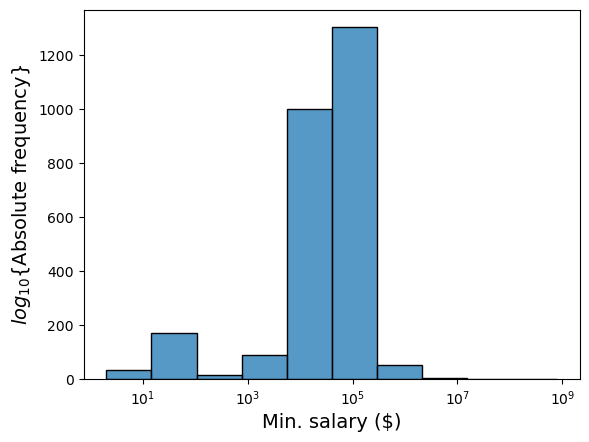

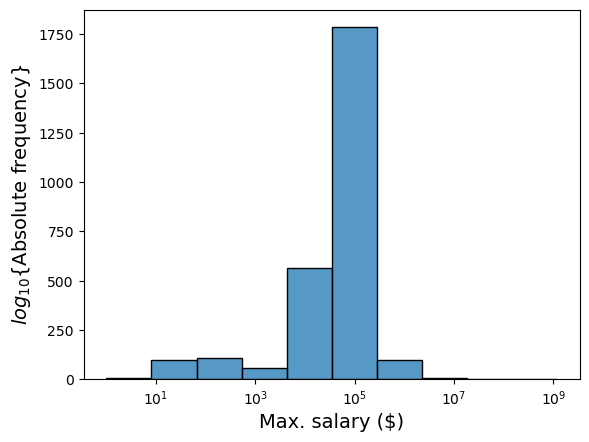

In [60]:
for column in ('min_salary', 'max_salary'):
    plt.figure()
    # Histogram:
    sns.histplot(data = df_1, x = column, bins = 10, log_scale = True)
    # Horizontal label:
    column_name = column.capitalize()
    column_name = '. '.join(column_name.split('_'))
    plt.xlabel(column_name + ' ($)', fontsize = 14)
    # Vertical label:
    plt.ylabel(r'$log_{10}${Absolute frequency}', fontsize = 14)

### 3.3. Boolean columns

For the columns that already have rows with only two possible values (**boolean**), the values are replaced with 0 or 1 and then set as *boolean*:

In [61]:
boolean_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']
df_1[boolean_columns] = df_1[boolean_columns].replace({'f': 0, 't': 1}).astype(bool)
df_1.head(1)

,title,location,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,min_salary,max_salary
0,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,False,True,True,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,False,20000,28000


As expected, there are considerably more non-fraudulent than fraudulent job ads. This could have negative effects in predicting if a job ad is either fraudulent or not, as there are less fraudulent examples. Therefore, a synthetic over-sampling technique will be used later to balance both classes.

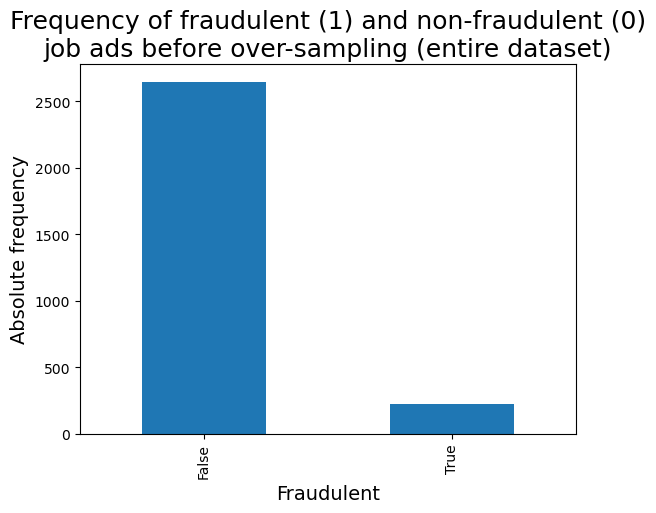

In [62]:
# Plot bar chart:
df_1['fraudulent'].value_counts().plot(kind='bar')
plt.xlabel('Fraudulent', fontsize = 14)
plt.ylabel('Absolute frequency', fontsize = 14)
title = [
        'Frequency of fraudulent (1) and non-fraudulent (0)',
        'job ads before over-sampling (entire dataset)'
        ]
plt.title('\n'.join(title), fontsize = 18)
plt.show()

### 3.4. Multi-valued categorical columns

The remaining columns are categorical and have multiple possible values.

Note that:
1. None of these columns contains a considerable amount of nulls, relative to the total number of rows
2. Only the ``title`` column contains a considerable amount of unique values, but **this column does not contain nulls**

These facts imply that it would be sensible to replace the nulls with the corresponding modes, i.e. the most frequent values.

In [63]:
# Convert the multi-valued categorical columns to the 'category' datatype:
df_1 = df_1.astype({
            column: 'category'
            for column in df_1.select_dtypes(include = 'str').columns
            })

In [64]:
df_1.info()
df_1.describe(include = 'all')

<class 'pandas.DataFrame'>
RangeIndex: 2868 entries, 0 to 2867
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   title                2868 non-null   category
 1   location             2846 non-null   category
 2   department           1285 non-null   category
 3   telecommuting        2868 non-null   bool    
 4   has_company_logo     2868 non-null   bool    
 5   has_questions        2868 non-null   bool    
 6   employment_type      2815 non-null   category
 7   required_experience  2536 non-null   category
 8   required_education   2364 non-null   category
 9   industry             2735 non-null   category
 10  function             2628 non-null   category
 11  fraudulent           2868 non-null   bool    
 12  min_salary           2868 non-null   int64   
 13  max_salary           2868 non-null   int64   
dtypes: bool(4), category(8), int64(2)
memory usage: 115.4 KB


,title,location,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,min_salary,max_salary
count,2868,2846,1285,2868,2868,2868,2815,2536,2364,2735,2628,2868,2.868000e+03,2.868000e+03
unique,2204,841,416,2,2,2,5,7,13,116,37,2,NaN,NaN
top,Customer Service Representative,"GB, LND, London",Sales,False,True,False,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,False,NaN,NaN
freq,32,194,134,2650,2127,1441,2478,846,1106,457,475,2645,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.107376e+05,8.049358e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.761278e+07,2.692976e+07
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.737500e+04,2.500000e+04
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.500000e+04,5.000000e+04
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000e+04,9.000000e+04


In [65]:
for column in df_1.columns:
    # No. of nulls in COLUMN:
    null_count = df_1[column].isna().sum()
    # Replace NaNs with the mode of COLUMN:
    if null_count > 0:
        mode = df_1[column].mode()[0]
        df_1[column] = df_1[column].fillna(mode)

df_1.info()

<class 'pandas.DataFrame'>
RangeIndex: 2868 entries, 0 to 2867
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   title                2868 non-null   category
 1   location             2868 non-null   category
 2   department           2868 non-null   category
 3   telecommuting        2868 non-null   bool    
 4   has_company_logo     2868 non-null   bool    
 5   has_questions        2868 non-null   bool    
 6   employment_type      2868 non-null   category
 7   required_experience  2868 non-null   category
 8   required_education   2868 non-null   category
 9   industry             2868 non-null   category
 10  function             2868 non-null   category
 11  fraudulent           2868 non-null   bool    
 12  min_salary           2868 non-null   int64   
 13  max_salary           2868 non-null   int64   
dtypes: bool(4), category(8), int64(2)
memory usage: 234.5 KB


### 3.5. Training and testing splits

The objective is to predict **fraudulent** job ads. Therefore, the column ``fraudulent`` is used as target, while the remaining columns are the predictive features:

In [66]:
# Separate the features from the target column 'fraudulent':
X = df_1.drop(columns = ['fraudulent']) # Features
y = df_1['fraudulent'].astype('int') # Target

The features and target are divided in training and testing splits. The idea is to be able to:
1. Train the model with a portion of the dataset
2. Test the model with data it has not already seen, in order to assess its predictive capabilities

In [67]:
# Training and testing split:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.33, # Fraction of the dataset that will be used for testing
    random_state = 42,
    stratify = y # Keep the proportion of target values in both splits
)

### 3.6. Over-sampling with synthetic data

In order to avoid the class imbalance from making it difficult for the ML model to correctly classify the minority class (fraudulent job ads), an over-sampling technique (``imblearn.over_sampling.SMOTENC``) is used **on the training data**.

Note that this is only applied to the training data, as the idea is to then test the models with real (not synthetic) data.

In [68]:
# Columns with two (boolean) or more categorical values:
categorical_columns = list(
                    X.select_dtypes(include = ['category', 'bool']).columns
                    )
# Indices of the categorical columns inside the features dataset (X):
categorical_columns_indices = [
                        X.columns.get_loc(column)
                        for column in categorical_columns
                        ]
# SMOTE-NC over-sampling of the minority class:
smote_nc = SMOTENC(
    categorical_features = categorical_columns_indices,
    random_state = 0
    )
X_train_oversampled, y_train_oversampled = smote_nc.fit_resample(
                                                            X_train, y_train
                                                            )

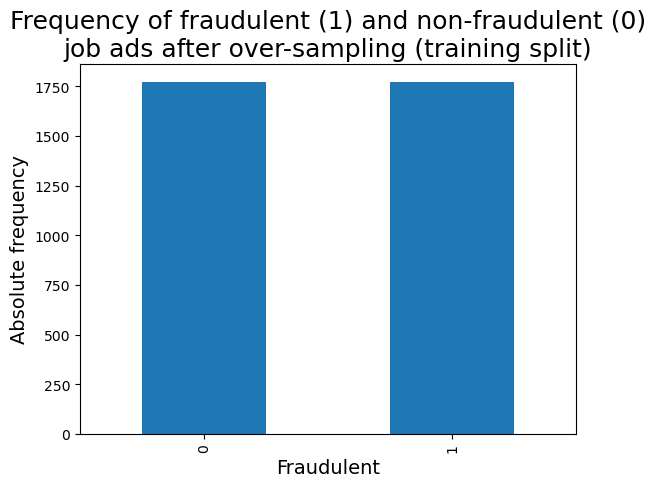

In [69]:
# Plot bar chart of the 'fraudulent' column after over-sampling:
y_train_oversampled.value_counts().plot(kind='bar')
plt.xlabel('Fraudulent', fontsize = 14)
plt.ylabel('Absolute frequency', fontsize = 14)
title = [
        'Frequency of fraudulent (1) and non-fraudulent (0)',
        'job ads after over-sampling (training split)'
        ]
plt.title('\n'.join(title), fontsize = 18)
plt.show()

## 4. Logistic Regression <a class="anchor" id="logistic_regression"></a>

The first model consists on:
1. **One-Hot encoding** the multi-valued categorical columns
2. **Standard scaling** the numeric columns
3. **Training** (with the over-sampled training split) a `sklearn.linear_model.LogisticRegression` over a distribution of hyper parameters (through `sklearn.model_selection.RandomizedSearchCV`) and using the model that maximizes the chosen **scoring metric**
4. **Predicting** the target's values by using the testing split on the best model
5. **Measuring** the model's performance with multiple metrics and the confusion matrix

A commonly used metric is **Accuracy**:
\begin{align*}
\operatorname{Accuracy}\equiv\frac{\operatorname{TP + TN}}{\operatorname{TP} + \operatorname{FP} + \operatorname{FN} + \operatorname{TN}}
\end{align*}
- **TP**: true positives, i.e. fraudulent job ads identified as such by the model
- **TN**: true negatives, i.e. non-fraudulent job ads identified as such by the model
- **FP**: false positives, i.e. non-fraudulent job ads incorrectly identified as fraudulent by the model
- **FN**: false negatives, i.e. fraudulent job ads incorrectly identified as non-fraudulent by the model

However, being a fraud detection problem, the idea would be to:
1. Out of all the fraudulent job ads, identify as many as possible. This would be equivalent to penalizing the TP by the FN,  i.e. maximize **Recall**:
\begin{align*}
\operatorname{Recall}\equiv\frac{\operatorname{TP}}{\operatorname{TP} + \operatorname{FN}}
\end{align*}
2. Avoid identifying FP, i.e. maximize **Precision**:
\begin{align*}
\operatorname{Precision}\equiv\frac{\operatorname{TP}}{\operatorname{TP} + \operatorname{FP}}
\end{align*}

A mix of the two metrics would be the **F1 score**, which penalizes both FN and FP:
\begin{align*}
\operatorname{F1}\equiv\frac{2\cdot\operatorname{Precision}\cdot\operatorname{Recall}}{\operatorname{Precision}+\operatorname{Recall}}
\end{align*}
Therefore, the **F1 score** will be used as the **scoring metric** for deciding which logistic regression model is the best.

In [70]:
# Train a logistic regression model:
model = regression_and_metrics.create_and_fit_regression(
    X_train = X_train_oversampled,
    y_train = y_train_oversampled,
    search__scoring = 'f1' # Scoring metric
)

Results of RandomizedSearchCV
------------------------------
Best hyper parameters: {'classifier__solver': 'liblinear', 'classifier__l1_ratio': 1, 'classifier__class_weight': None, 'classifier__C': np.float64(215.44346900318823)}
Best f1 score: 0.9809221375154671



After training the ML model and being able to predict the probability of each job ad being fraudulent, it is necessary to define a **threshold**: **if a job ad's probability of being fraudulent is higher than this threshold, then it is categorized as fraudulent**.

The default threshold is 50%. Then, in terms of Precision and Recall, there are two options:
1. A **higher threshold** means reducing FP and increasing FN, i.e. **increases Precision and decreases Recall**
2. A **lower threshold** means reducing FN and increasing FP, i.e. **decreases Precision and increases Recall**

In the detection **fraudulent job ads**, the cost of FP is generally higher than the cost of FN. Therefore, it is better to set a **higher threshold**, e.g. 80%.

Model metrics
---------------------------------------------
Accuracy:       0.9630411826821542
Precision:      0.8679245283018868
Recall:         0.6216216216216216
F1:             0.7244094488188977


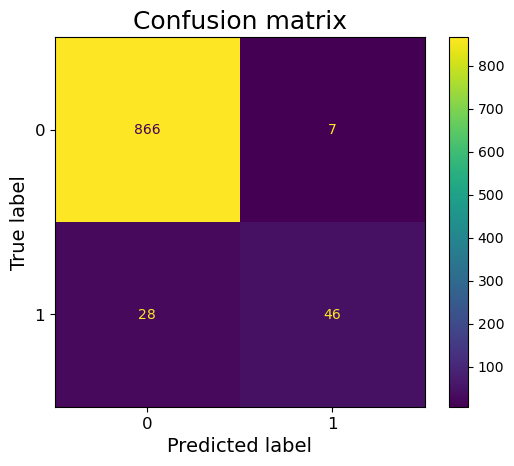

In [71]:
# Define fraudulent job ads as those with a probability >= FRAUDULENT_THRESHOLD:
FRAUDULENT_THRESHOLD = 0.8

# Predict probability of each job ad being fraudulent:
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Apply the categorization threshold:
y_pred = (y_pred_proba >= FRAUDULENT_THRESHOLD).astype(int)

# Show metrics and confusion matrix:
regression_and_metrics.show_model_metrics(y_test, y_pred)
regression_and_metrics.show_confusion_matrix(
            y_pred = y_pred,
            y_true = y_test
            )

The simple **logistic regression model** achieves a decent **F1** score $>70\%$. As expected, **Precision** is high ($>85\%$), while **Recall** is considerably lower ($\sim62\%$).

It remains to see the model's performance after dimensionality reduction.

## 5. Dimensionality reduction with Autoencoders <a class="anchor" id="autoencoders"></a>

### 5.1. Autoencoder without hidden layers

The simplest **Autoencoder model** includes only two Dense layers: one for the Encoder and another for the Decoder. This model:
1. **Encodes** the input data to a given dimension, i.e. reduces the data to a lower dimension **latent representation**
2. **Decodes** the latent representation, trying to reconstruct the higher dimension original data

After training the **Autoencoder model** to encode and decode the features' training split, the idea would be to:
1. Use the trained **Encoder** to create a **latent representation of the features' testing split**
2. Create a new **logistic regression** model, trained again over a distribution of hyper parameters
3. Input the **latent representation of the features' training split** into the **logistic regression** model, in order to predict the corresponding target column's values
4. Compare the predicted target values with the true values

In [72]:
# Pre-process the training split of the features in order to calculate the
# resulting number of features (after One-Hot encoding):
preprocessor = preprocessing.create_preprocessor(X_train_oversampled)
X_train_processed = preprocessor.fit_transform(X_train_oversampled)

In [73]:
# Number of resulting components after encoding the features:
ENCODING_DIMENSION = int(X_train_processed.shape[1] * 0.75)

# Create and fit an autoencoder model without hidden layers:
_, encoder_0, _ = autoencoding.create_and_fit_autoencoder(
    X_train = X_train_oversampled,
    encoding_dimension = ENCODING_DIMENSION,
    hidden_layers_dimensions = None,
    optimizer = 'rmsprop',
    training__epochs = 100,
    regularization__batch_normalization = False,
    regularization__dropout_rate = None,
    regularization__l1 = None,
    regularization__l2 = None,
    reduce_learning_rate__patience = 3,
    early_stopping__patience = 10
)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 2690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2017)           │     5,427,747 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 2690)           │     5,428,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,856,167 (41.41 MB)

 Trainable params: 10,856,167 (41.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0217 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0165 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0149 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0142 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0138 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0134 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0130 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0127 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0125 - val_loss: 0.0083 - learning_rate:

Results of RandomizedSearchCV
------------------------------
Best hyper parameters: {'classifier__solver': 'liblinear', 'classifier__l1_ratio': 0, 'classifier__class_weight': 'balanced', 'classifier__C': np.float64(46.41588833612773)}
Best f1 score: 0.98054442456301

Model metrics
---------------------------------------------
Accuracy:       0.9672650475184794
Precision:      0.8909090909090909
Recall:         0.6621621621621622
F1:             0.7596899224806202


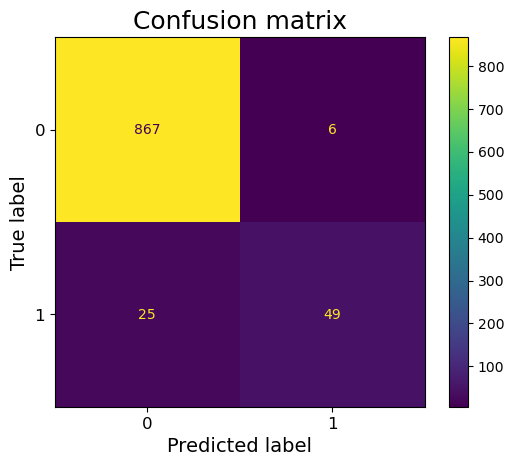

In [74]:
# Evaluate the performance of the encoder without hidden layers:
autoencoding.evaluate_encoder(
    encoder = encoder_0,
    X_train = X_train_oversampled,
    X_test = X_test,
    y_train = y_train_oversampled,
    y_test = y_test
)

Comparing the results of the **Autoencoder without hidden layers** vs. the model with **no Autoencoder**:
- Accuracy has slightly increased
- **Precision, Recall and F1 have increased considerably** after using the **Autoencoder without hidden layers** for dimensionality reduction

**A disadvantage of using no hidden layers is the limited capacity for the model to capture non-linearities**, although it should capture more than Principal Component Analysis.

### 5.2. Autoencoder with two hidden layers and no regularization

Now, an **Autoencoder with two hidden layers** (one for the encoder and one for the decoder) is created:

In [75]:
ENCODING_DIMENSION = int(X_train_processed.shape[1] * 0.75)
HIDDEN_DIMENSIONS = (int(X_train_processed.shape[1] * 0.925),)

# Create and fit an autoencoder model with two hidden layers:
_, encoder_1, _ = autoencoding.create_and_fit_autoencoder(
    X_train = X_train_oversampled,
    encoding_dimension = ENCODING_DIMENSION,
    hidden_layers_dimensions = HIDDEN_DIMENSIONS,
    training__epochs = 100,
    optimizer = 'rmsprop',
    regularization__batch_normalization = False,
    regularization__dropout_rate = None,
    regularization__l1 = None,
    regularization__l2 = None,
    reduce_learning_rate__patience = 3,
    early_stopping__patience = 10
)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 2690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2017)           │    11,715,521 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 2690)           │    11,716,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,431,715 (89.38 MB)

 Trainable params: 23,431,715 (89.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0243 - val_loss: 0.0164 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0190 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0182 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0176 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0170 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0166 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0163 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0160 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0173 - val_loss: 0.0119 - learning_rate:

Results of RandomizedSearchCV
------------------------------
Best hyper parameters: {'classifier__solver': 'liblinear', 'classifier__l1_ratio': 0, 'classifier__class_weight': None, 'classifier__C': np.float64(1000.0)}
Best f1 score: 0.9766754563226746

Model metrics
---------------------------------------------
Accuracy:       0.9524815205913411
Precision:      0.7735849056603774
Recall:         0.5540540540540541
F1:             0.6456692913385826


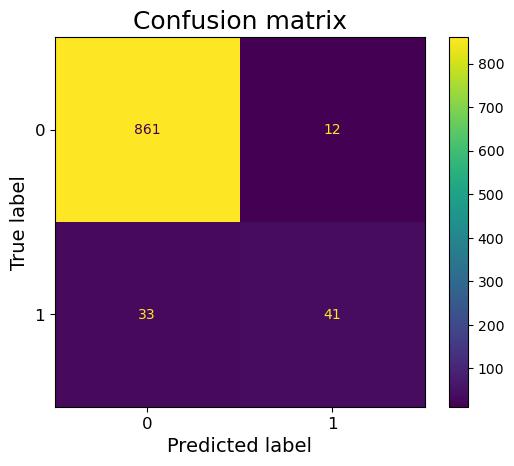

In [76]:
# Evaluate the performance of the encoder with one hidden layer:
autoencoding.evaluate_encoder(
    encoder = encoder_1,
    X_train = X_train_oversampled,
    X_test = X_test,
    y_train = y_train_oversampled,
    y_test = y_test
)

Although this is a more complex model that should be able to capture more non-linearities than the previous one, **the addition of hidden layers has considerably decreased the model's performance in all metrics**.

### 5.3. Autoencoder with two hidden layers and regularization

An option to address the decrease in performance is to add **regularization** techniques:
1. **Batch Normalization inside the Encoder:** for each iteration/mini-batch, normalize the result of the previous hidden layer by its mean and standard deviation. Helps by reducing the training time and providing more stability to the network (as the gradients do not become too big or small)
2. **Dropout layer inside the Encoder:** for each iteration/mini-batch, avoid using a fraction of the neurons of the previous hidden layer, so the network cannot memorize specific paths or combinations. Helps by reducing over-fitting by the Encoder
3. **L1 (Lasso) and L2 (Ridge) regularization in all Dense layers:** smoothen the values and reduce the risk of over-fitting

In [77]:
ENCODING_DIMENSION = int(X_train_processed.shape[1] * 0.75)
HIDDEN_DIMENSIONS = (int(X_train_processed.shape[1] * 0.925),)

# Create and fit an autoencoder model with two hidden layers and regularization:
_, encoder_2, _ = autoencoding.create_and_fit_autoencoder(
    X_train = X_train_oversampled,
    encoding_dimension = ENCODING_DIMENSION,
    hidden_layers_dimensions = HIDDEN_DIMENSIONS,
    training__epochs = 200,
    optimizer = 'rmsprop',
    regularization__batch_normalization = True,
    regularization__dropout_rate = 0.1,
    regularization__l1 = 1e-4,
    regularization__l2 = 1e-4,
    reduce_learning_rate__patience = 5,
    early_stopping__patience = 10,
    #initial_learning_rate = 1e-3,
    #reduce_learning_rate__factor = 0.9
)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 2690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2017)           │    11,725,473 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 2690)           │    11,716,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,441,667 (89.42 MB)

 Trainable params: 23,436,691 (89.40 MB)

 Non-trainable params: 4,976 (19.44 KB)

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 18.2058 - val_loss: 2.3522 - learning_rate: 0.0010
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - loss: 0.7593 - val_loss: 0.3871 - learning_rate: 0.0010
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - loss: 0.3866 - val_loss: 0.3847 - learning_rate: 0.0010
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 0.3857 - val_loss: 0.3843 - learning_rate: 0.0010
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 0.3854 - val_loss: 0.3840 - learning_rate: 0.0010
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 0.3852 - val_loss: 0.3839 - learning_rate: 0.0010
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.3850 - val_loss: 0.3839 - learning_rate: 0.0010
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 0.3850 - val_loss: 0.3838 - learning_rate: 0.0010
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - loss: 0.3849 - val_loss: 0.38

Results of RandomizedSearchCV
------------------------------
Best hyper parameters: {'classifier__solver': 'liblinear', 'classifier__l1_ratio': 1, 'classifier__class_weight': None, 'classifier__C': np.float64(215.44346900318823)}
Best f1 score: 0.7810796270852578

Model metrics
---------------------------------------------
Accuracy:       0.9271383315733897
Precision:      0.7777777777777778
Recall:         0.0945945945945946
F1:             0.1686746987951807


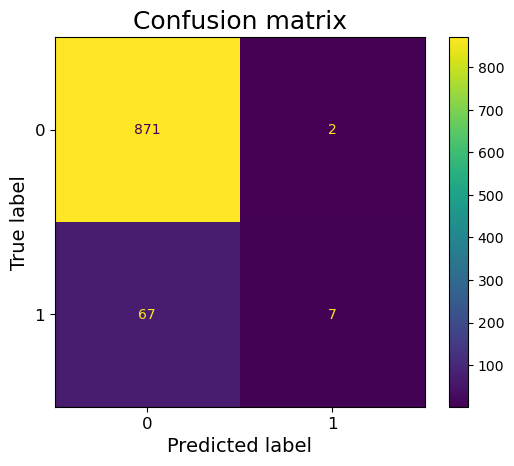

In [78]:
# Evaluate the performance of the encoder with one hidden layer and
# regularization:
autoencoding.evaluate_encoder(
    encoder = encoder_2,
    X_train = X_train_oversampled,
    X_test = X_test,
    y_train = y_train_oversampled,
    y_test = y_test
)

By adding **regularization techniques** to the **Autoencoder with two hidden layers**:
1. Accuracy has decreased slightly, reaching its lowest value across al models
2. **Precision** has increased slightly above the value obtained for the **Autoencoder with two hidden layers and no regularization**, but is still lower than the values obtained with the **Autoencoder without hidden layers** and **without an Autoencoder**
3. **Recall** has decreased drastically to its loweest value across al models, driving the **F1** score to also decrease drastically

It is possible that the training epochs for the last model were not enough (although it was already trained for more epochs than the previous models), due to the increase in complexity. In any case, it would be necessary to refine the last model, if wanting to further explore the possible advantages of a deeper NN on dimensionality reduction.

It would appear that, in this case and until the deeper NN is refined, the simple **Autoencoder without hidden layers** is an easy, fast and effective dimensionality reduction technique, providing a considerable improvement over using the whole dataset to make predictions.